# SONYC WSP Mini-Project

### Construction Complaint Pattern Identification

This work aims to identify patterns in construction-related noise complaints surrounding the Washington Square Park area, where there is currently an NYC DDC capital project of replacing sewers and water mains. 
June 15, 2019

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce

# Geospatial
import shapely
import geopandas as gp
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
from shapely.geometry import Point, MultiPoint
import io
from geopandas.tools import sjoin
from shapely.ops import nearest_points
from shapely.ops import cascaded_union


# Geopy for finding lat/long coordinates
import geopy
from geopy.geocoders import Nominatim
import geopy.distance
geolocator = Nominatim(user_agent = 'random')

import warnings
warnings.filterwarnings(action='once')

from sodapy import Socrata
from APPTOKEN import myToken
## Save your SOTA API Token as variable myToken in a file titled SOTAPY_APPTOKEN.py
## e.g.
## myToken = 'XXXXXXXXXXXXXXXX'

## Read in Data

### DEP Complaints

### Noise Complaints - All Types

In [2]:
endpoint = 'https://data.cityofnewyork.us/resource/p5f6-bkga.json'
domain = 'data.cityofnewyork.us'
data_id = 'p5f6-bkga'
token = myToken
client = Socrata(domain, token)

metadata = client.get_metadata(data_id)
columns = [x['name'] for x in metadata['columns']]
meta_amount = [x for x in metadata['columns'] if x['name'] == 'Borough'][0]
meta_amount

{'id': 355588975,
 'name': 'Borough',
 'dataTypeName': 'text',
 'description': 'Provided by the submitter and confirmed by geovalidation.\n',
 'fieldName': 'borough',
 'position': 26,
 'renderTypeName': 'text',
 'tableColumnId': 1567810,
 'width': 184,
 'cachedContents': {'largest': 'Unspecified',
  'non_null': 3031834,
  'null': 0,
  'top': [{'item': 'BROOKLYN', 'count': 20},
   {'item': 'MANHATTAN', 'count': 19},
   {'item': 'STATEN ISLAND', 'count': 18},
   {'item': 'QUEENS', 'count': 17},
   {'item': 'BRONX', 'count': 16},
   {'item': 'Unspecified', 'count': 15}],
  'smallest': 'BRONX'},
 'format': {}}

In [4]:
a=2
results = []
for i in range(a):
    query ="""
    select
        borough,
        created_date,
        community_board,
        agency,
        complaint_type, descriptor, location_type, incident_zip,
        incident_address, street_name, cross_street_1, cross_street_2,
        intersection_street_1, intersection_street_2,
        resolution_description, latitude, longitude, location
    where
        community_board ='02 MANHATTAN' or
        community_board = 'Unspecified MANHATTAN'
    limit
        50000
    offset
        {}
    """.format(i*50000)
    results = results + client.get(data_id, query=query)
    print("Total number of non-null results: {}".format(meta_amount['cachedContents']['non_null']))
    print("Number of results downloaded: {}".format(len(results)))

complaints = pd.DataFrame(results)

Total number of non-null results: 3031834
Number of results downloaded: 50000
Total number of non-null results: 3031834
Number of results downloaded: 82012


### Noise Sensor Node Locations

In [5]:
nodes = pd.read_csv('../data/relevant_nodes.csv')

nodes['lonlat']=list(zip(nodes.longitude.astype(float), nodes.latitude.astype(float)))
nodes['geometry']=nodes[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
crs = {'init':'epsg:4326', 'no_defs': True}
nodes = gp.GeoDataFrame(nodes, crs=crs, geometry=nodes['geometry'])

In [6]:
nodes.drop(columns=['Unnamed: 0', 'lonlat','node_id'],inplace=True)

### Streets and Parks Shapefiles

In [7]:
## Read in streets shapefile to get street names
streets = gp.read_file('https://data.cityofnewyork.us/api/geospatial/exjm-f27b?method=export&format=GeoJSON')
streets = streets[streets.borocode == '1']
streets.drop(columns = ['rw_type', 'l_low_hn', 'pre_direct', 'st_width', 'r_zip', 'r_low_hn',
       'bike_lane', 'r_blkfc_id', 'bike_trafd', 'frm_lvl_co',
       'post_modif', 'pre_type','trafdir', 'pre_modifi', 'created', 'l_high_hn'], inplace=True)


In [8]:
## NYC Parks shapefile to get WSP
nycParks = gp.read_file('https://data.cityofnewyork.us/api/geospatial/rjaj-zgq7?method=export&format=GeoJSON')
WSP = nycParks[nycParks.index == 240][['propname', 'geometry']]
WSP['geometry'][240] = cascaded_union([nycParks['geometry'][236],nycParks['geometry'][240]])

### 1000 ft Offset from WSP

Creating a 1000 foot buffer offset from Washington Square Park and performing a spatial join with the streets shapefile to find which streets to look for that are within 1000 feet of washington square park. We will then be able to limit the search for the street construction permits and reduce the computing load of geocoding all street construction work.

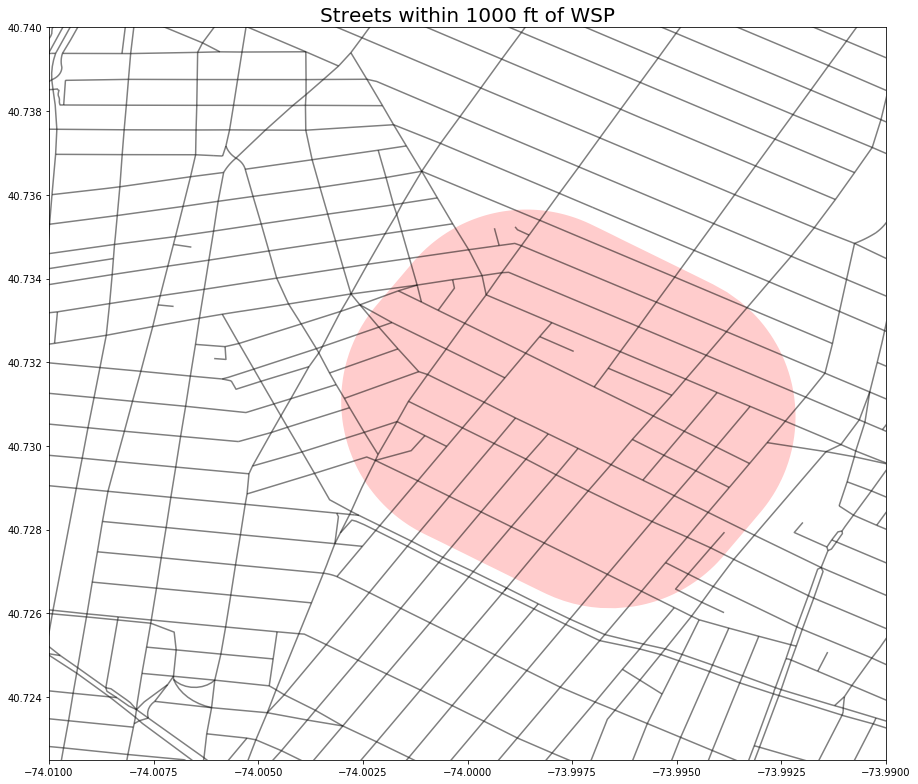

In [9]:
f, ax = plt.subplots(figsize=(15,15))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim((-74.01,-73.99))
ax.set_ylim((40.7225,40.74))
WSP.buffer(0.0035).plot(ax=ax, color='r', alpha = 0.2)
streets.plot(ax=ax, edgecolor='k',alpha=0.5, label='WSP')

plt.title("Streets within 1000 ft of WSP", size=20)
plt.show()

In [10]:
WSP_buffer = WSP.copy()
WSP_buffer['geometry'] = WSP.buffer(0.004)

WSP_st_buffer = sjoin(streets,WSP_buffer)
WSP_st_buffer.drop(columns = ['l_blkfc_id', 'shape_leng', 'to_lvl_co', 'modified',
       'status', 'post_direc', 'r_high_hn', 'l_zip', 'snow_pri', 'borocode','physicalid','index_right',
       'propname'],inplace=True)


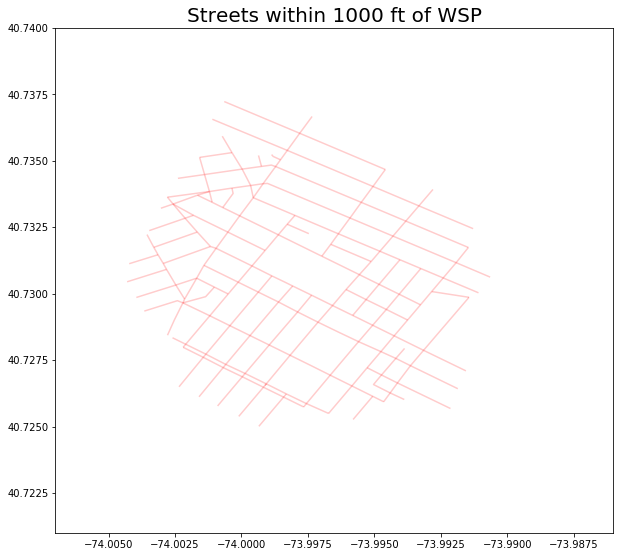

In [11]:
f, ax = plt.subplots(figsize=(10,10))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim((-74.007,-73.986))
ax.set_ylim((40.721,40.74))
WSP_st_buffer.plot(ax=ax, color='r', alpha = 0.2)

plt.title("Streets within 1000 ft of WSP", size=20)
plt.show()

### Street Construction Permits

In [12]:
permits = pd.read_csv('WSP_street_construction.csv', usecols= ['createdon', 'fromstreetname',
       'issuedworkenddate', 'issuedworkstartdate', 'onstreetname',
       'permithousenumber', 'permitissuedate', 'permitlinearfeet',
       'permitstatusid', 'permitteename', 'tostreetname', 'latitude',
       'longitude'    ])


## Data Cleaning

In [16]:
len(complaints[((complaints.latitude.isna()) | 
                           (complaints.longitude.isna()))])/len(complaints)

0.0285689899039165

In [13]:
## Finding the index of complaints where lat/long is missing 
## & there is address info

fill_address = complaints[((complaints.latitude.isna()) | 
                           (complaints.longitude.isna()))].index

In [14]:
def numberedst(s):
    x = None
    for stype in [' AVENUE',' STREET']:
        if stype in s:
            a = s.split(stype)[0]
            b = list(filter(None, a.split(' ')))
            for seg in b:
                if len(seg) > 1:
                    if seg[-2] == '1':
                        x = reduce(lambda x, y: x +' ' + y, b) + 'th' + stype
                        continue
                if seg[-1] == '1':
                    x = reduce(lambda x, y: x +' ' + y, b) + 'st' + stype
                elif seg[-1] == '2':
                    x = reduce(lambda x, y: x +' ' + y, b) + 'nd' + stype
                elif seg[-1] == '3':
                    x = reduce(lambda x, y: x +' ' + y, b) + 'rd' + stype
                elif seg.isdigit() == True:
                    x = reduce(lambda x, y: x +' ' + y, b) + 'th' + stype
    if x:
        return x
    else:
        return s

In [15]:
farStreets = list(['W {} ST'.format(i) for i in range(10,200)] +
                ['E {} ST'.format(i) for i in range(10,200)] +
                 ['WEST {} ST'.format(i) for i in range(10,200)] + 
                ['EAST {} ST'.format(i) for i in range(10,200)] +
                 ['AVENUE A', 'AVENUE B','WATER ST','ST LENOX AVE','SPRING STREET',
                 'PERRY STREET','26 PCT','AMSTERDAM HOUSES','BETHUNE STREET','CABRINI AVE',
                 'DYER AVENUE','BRYANT PARK','DESBROSSES ST','DUTCH ST','FULTON STREET',
                 'STANTON ST','READE ST','BATTERY TUNNEL','EAST   20 STREET','LIBERTY ISLAND',
                 'HORATIO STREET','RECTOR PLACE','CLINTON HOUSES','URBAN ACADEMY','BATTERY PARK',
                 '3 AVE','2 AVE','1 AVE','COOPER SQUARE','LIBERTY ST','GREENWICH STREET','LINCOLN TUNNEL',
                 'COOPER UNION','PRINCE ST','F D R DRIVE','FDR DRIVE','BOWERY'])

In [17]:
for i in fill_address:
    street = complaints['incident_address'][i]
    crossSt = complaints['cross_street_1'][i]
    
    if type(street) == float or type(crossSt) == float:
        continue
    
    if street in farStreets:
        continue
        
    if crossSt in farStreets:
        continue
        
    if complaints['incident_address'][i] != complaints['street_name'][i]:
        loc = geolocator.geocode(street + ', NY')
        if loc:
            complaints['latitude'][i] = loc.latitude
            complaints['longitude'][i] = loc.longitude
            continue
        
    street = numberedst(street)
    crossSt = numberedst(crossSt)
    
    try:
        loc = geolocator.geocode(street + ' & ' + crossSt + ', NY')
        complaints['latitude'][i] = loc.latitude
        complaints['longitude'][i] = loc.longitude
    except:
        try:
            crossSt = numberedst(complaints['cross_street_2'][i])
            if crossSt in farStreets:
                continue
            
            loc = geolocator.geocode(street+ ' & '+ crossSt + ', New York')
            complaints['latitude'][i] = loc.latitude
            complaints['longitude'][i] = loc.longitude
        except:
            continue

Most of those addresses are all farther than 1000 feet from Washington Square Park, with the exception of the following:  <br /> 
-Bleecker & 6th Ave (Ave of Americas) <br /> 
-Mercer St & West 3rd Street <br /> 
-LaGuardia Place & West 3rd Street  <br /> 
-Washington Square Park & Thompson Street (& W 4th street)
 <br /> <br /> 
 Therefore I will manually input an arbitrary address near those intersections. 
 

In [18]:
## For Bleecker street & 6th avenue // Avenue of the Americas
loc = geolocator.geocode('268 6th Ave, New York, NY 10014')
for i in [16698, 18414, 19002,41685,44235,48212,49496,59045,50692, 61258]:
    complaints['latitude'][i] = loc.latitude
    complaints['longitude'][i] = loc.longitude
    
## For LaGuardia Place & West 3rd Street
loc = geolocator.geocode('552 LaGuardia Pl, New York, NY 10012')
for i in [1674,1671,45348,69703]:
    complaints['latitude'][i] = loc.latitude
    complaints['longitude'][i] = loc.longitude
    
## For Mercer st & West 3rd Street
loc = geolocator.geocode('248 Mercer St, New York, NY 10012')
for i in [363, 1366]:
    complaints['latitude'][i] = loc.latitude
    complaints['longitude'][i] = loc.longitude
    
## For Washington square park & thompson St
loc = geolocator.geocode(' 55 Washington Square S, New York, NY 10012')
for i in [5454, 68234]:
    complaints['latitude'][i] = loc.latitude
    complaints['longitude'][i] = loc.longitude


In [19]:
complaints.dropna(subset=['longitude', 'latitude'],inplace=True)
complaints['created_date'] = pd.to_datetime(complaints['created_date'])
complaints['createdate'] = complaints['created_date'].apply(lambda x: x.date())
#complaints = complaints[complaints.createdate >= datetime.datetime(2018,1,1)]
#complaints = complaints[complaints.createdate < datetime.datetime(2019,1,1)]
complaints['lonlat']=list(zip(complaints.longitude.astype(float), complaints.latitude.astype(float)))
complaints['geometry']=complaints[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
crs = {'init':'epsg:4326', 'no_defs': True}
complaints = gp.GeoDataFrame(complaints, crs=crs, geometry=complaints['geometry'])


In [20]:
## Perform spatial join of the complaints to the Washington Square Buffer
WSP_buffer.crs = complaints.crs
complaints = sjoin(complaints, WSP_buffer)

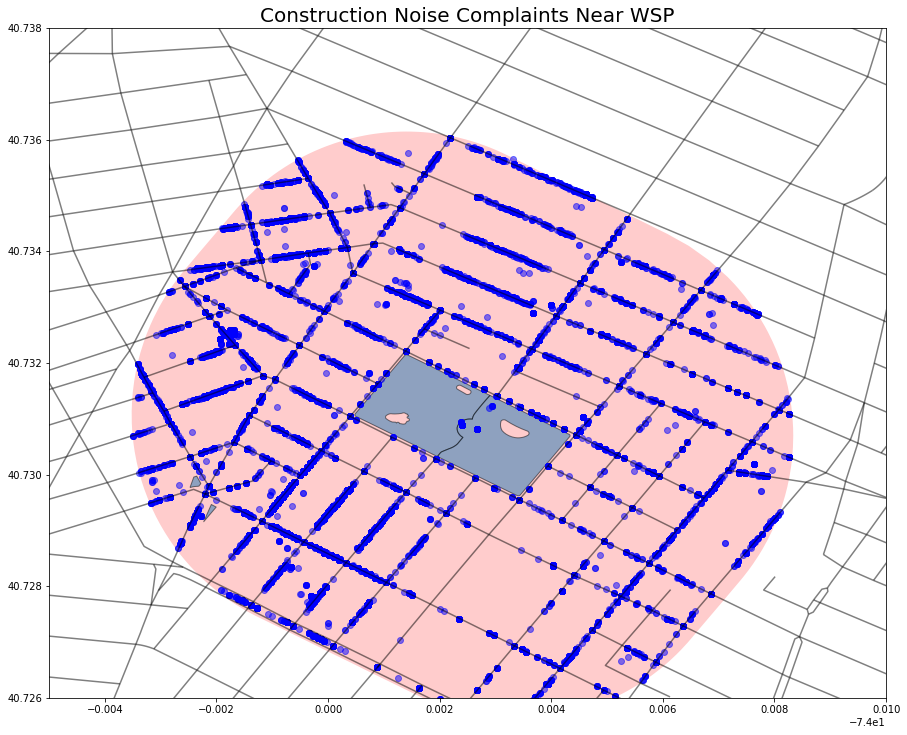

In [24]:
f, ax = plt.subplots(figsize=(15,15))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim((-74.005,-73.99))
ax.set_ylim((40.726,40.738))
WSP_buffer.plot(ax=ax, color='r', alpha = 0.2)
streets.plot(ax=ax, color = 'k', alpha = 0.5)
nycParks.plot(ax=ax, edgecolor='k',alpha=0.5, label='WSP')
complaints.plot(ax=ax, color='blue', alpha = 0.5, label='Complaints')

plt.title("Construction Noise Complaints Near WSP", size=20)
plt.show()

In [32]:
complaints.drop(columns=['borough','community_board','index_right','propname','lonlat'],inplace=True)

In [25]:
constrcomplaints = complaints[(complaints.descriptor == 'Noise: Construction Before/After Hours (NM1)' )|
                       (complaints.descriptor == 'Noise: Jack Hammering (NC2)' )|
                        (complaints.descriptor == 'Noise: Construction Equipment (NC1)') |
                       (complaints.descriptor == 'Construction Before/After Hours - For DEP Internal Use Only') ]
                        


## Construction Permit-Complaint Association

We want to group noise complaints that were made within a certain proximity of street constructionpermits to identify if there is indeed a correlation between actual noise decibel data and complaints.

In [26]:
permits = permits [permits.latitude != 0.0]
permits.dropna(subset=['longitude', 'latitude'],inplace=True)
permits['issuedworkstartdate'] = pd.to_datetime(permits['issuedworkstartdate']).apply(lambda x: x.date())
permits['issuedworkenddate'] = pd.to_datetime(permits['issuedworkenddate']).apply(lambda x: x.date())

# permits = permits[permits.createdate >= datetime.datetime(2018,1,1)]
# permits = permits[permits.createdate < datetime.datetime(2019,1,1)]
permits['lonlat']=list(zip(permits.longitude.astype(float), permits.latitude.astype(float)))
permits['geometry']=permits[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
crs = {'init':'epsg:4326', 'no_defs': True}
permits = gp.GeoDataFrame(permits, crs=crs, geometry=permits['geometry'])


In [27]:
permits = sjoin(permits, WSP_buffer).drop(columns = ['index_right','propname'])

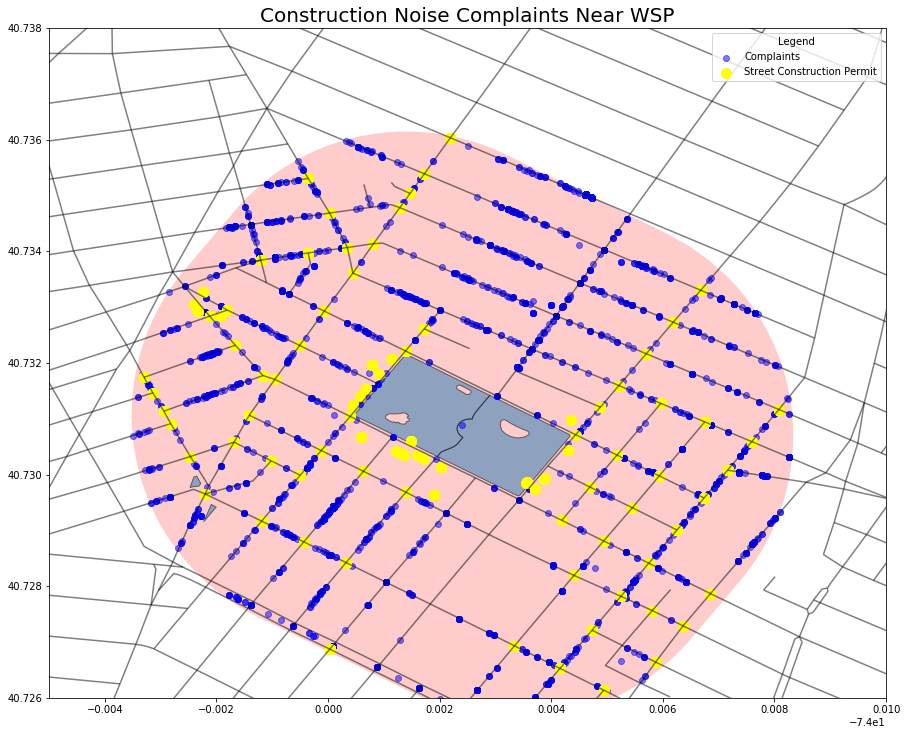

In [28]:
f, ax = plt.subplots(figsize=(15,15))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim((-74.005,-73.99))
ax.set_ylim((40.726,40.738))
WSP_buffer.plot(ax=ax, color='r', alpha = 0.2, label = 'WSP Buffer', legend=True)
streets.plot(ax=ax, color = 'k', alpha = 0.5)
nycParks.plot(ax=ax, edgecolor='k',alpha=0.5, label='WSP', legend = True)
constrcomplaints.plot(ax=ax, color='blue', alpha = 0.5, label='Complaints', legend=True)
permits.plot(ax=ax, color= 'yellow',markersize=100, label = 'Street Construction Permit', legend=True)

ax.legend(title="Legend")

plt.title("Construction Noise Complaints Near WSP", size=20)
plt.show()

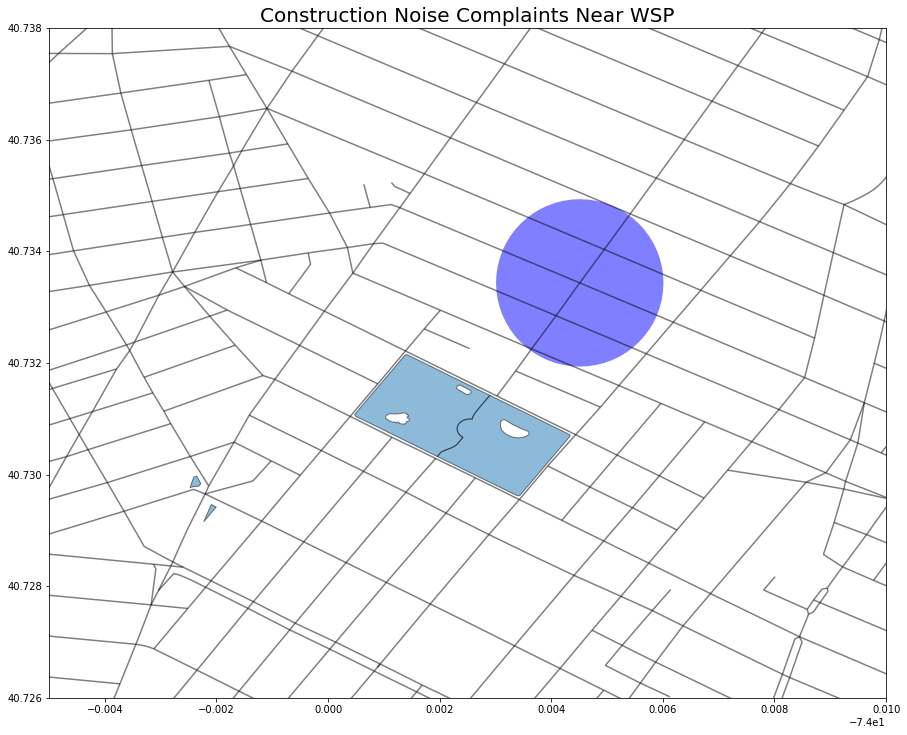

In [54]:
f, ax = plt.subplots(figsize=(15,15))
ax.set_xlim((-74.005,-73.99))
ax.set_ylim((40.726,40.738))
streets.plot(ax=ax, color = 'k', alpha = 0.5)
constrcomplaints[constrcomplaints.index == 8].buffer(0.0015).plot(ax=ax, color='blue', alpha = 0.5, label='Complaints')

nycParks.plot(ax=ax, edgecolor='k',alpha=0.5, label='WSP', legend = True)


plt.title("Construction Noise Complaints Near WSP", size=20)
plt.show()


In [55]:
constrcomplaints_buffer = constrcomplaints.copy()
constrcomplaints_buffer['geometry'] = constrcomplaints_buffer.buffer(0.0015)


In [63]:
permits.columns

Index(['createdon', 'fromstreetname', 'issuedworkenddate',
       'issuedworkstartdate', 'onstreetname', 'permithousenumber',
       'permitissuedate', 'permitlinearfeet', 'permitstatusid',
       'permitteename', 'tostreetname', 'latitude', 'longitude', 'lonlat',
       'geometry'],
      dtype='object')

In [62]:
sjoin(constrcomplaints_buffer[constrcomplaints_buffer.index == 168],permits)


,agency,complaint_type,created_date,cross_street_1,cross_street_2,descriptor,incident_address,incident_zip,intersection_street_1,intersection_street_2,...,onstreetname,permithousenumber,permitissuedate,permitlinearfeet,permitstatusid,permitteename,tostreetname,latitude_right,longitude_right,lonlat
168,DEP,Noise,2019-06-26 09:32:00,UNIVERSITY PL,5 AVE,Noise: Construction Before/After Hours (NM1),7 WASHINGTON SQUARE NORTH,10003,NaN,NaN,...,WASHINGTON SQUARE EAST,79,2015-08-11T15:13:23.000,NaN,030,ACTION CARTING ENVIRONMENTAL,WASHINGTON SQUARE SOUTH,40.729738,-73.996294,"(-73.9962939, 40.729738299999994)"
168,DEP,Noise,2019-06-26 09:32:00,UNIVERSITY PL,5 AVE,Noise: Construction Before/After Hours (NM1),7 WASHINGTON SQUARE NORTH,10003,NaN,NaN,...,WASHINGTON SQUARE EAST,79,2018-12-18T12:04:20.000,NaN,030,"ACTION CARTING ENVIRONMENTAL SERVICES, INC.",WASHINGTON SQUARE SOUTH,40.729738,-73.996294,"(-73.9962939, 40.729738299999994)"
168,DEP,Noise,2019-06-26 09:32:00,UNIVERSITY PL,5 AVE,Noise: Construction Before/After Hours (NM1),7 WASHINGTON SQUARE NORTH,10003,NaN,NaN,...,WASHINGTON SQUARE EAST,79,2014-09-22T11:11:37.000,NaN,030,CGI NORTHEAST INC,WASHINGTON SQUARE SOUTH,40.729738,-73.996294,"(-73.9962939, 40.729738299999994)"
168,DEP,Noise,2019-06-26 09:32:00,UNIVERSITY PL,5 AVE,Noise: Construction Before/After Hours (NM1),7 WASHINGTON SQUARE NORTH,10003,NaN,NaN,...,WASHINGTON SQUARE EAST,79,2018-12-07T10:49:56.000,NaN,030,"ACTION CARTING ENVIRONMENTAL SERVICES, INC.",WASHINGTON SQUARE SOUTH,40.729738,-73.996294,"(-73.9962939, 40.729738299999994)"
168,DEP,Noise,2019-06-26 09:32:00,UNIVERSITY PL,5 AVE,Noise: Construction Before/After Hours (NM1),7 WASHINGTON SQUARE NORTH,10003,NaN,NaN,...,WASHINGTON SQUARE EAST,79,2014-10-31T14:22:28.000,NaN,030,SKYLINE RESTORATION INC.,WASHINGTON SQUARE SOUTH,40.729738,-73.996294,"(-73.9962939, 40.729738299999994)"
168,DEP,Noise,2019-06-26 09:32:00,UNIVERSITY PL,5 AVE,Noise: Construction Before/After Hours (NM1),7 WASHINGTON SQUARE NORTH,10003,NaN,NaN,...,WASHINGTON SQUARE EAST,79,2015-01-05T08:59:31.000,NaN,030,SKYLINE RESTORATION INC.,WASHINGTON SQUARE SOUTH,40.729738,-73.996294,"(-73.9962939, 40.729738299999994)"
168,DEP,Noise,2019-06-26 09:32:00,UNIVERSITY PL,5 AVE,Noise: Construction Before/After Hours (NM1),7 WASHINGTON SQUARE NORTH,10003,NaN,NaN,...,WASHINGTON SQUARE EAST,79,2014-07-15T10:13:05.000,NaN,030,ACTION CARTING ENVIRONMENTAL,WASHINGTON SQUARE SOUTH,40.729738,-73.996294,"(-73.9962939, 40.729738299999994)"
168,DEP,Noise,2019-06-26 09:32:00,UNIVERSITY PL,5 AVE,Noise: Construction Before/After Hours (NM1),7 WASHINGTON SQUARE NORTH,10003,NaN,NaN,...,WASHINGTON SQUARE EAST,79,2018-12-03T17:47:33.000,NaN,030,"ACTION CARTING ENVIRONMENTAL SERVICES, INC.",WASHINGTON SQUARE SOUTH,40.729738,-73.996294,"(-73.9962939, 40.729738299999994)"
168,DEP,Noise,2019-06-26 09:32:00,UNIVERSITY PL,5 AVE,Noise: Construction Before/After Hours (NM1),7 WASHINGTON SQUARE NORTH,10003,NaN,NaN,...,WASHINGTON SQUARE EAST,79,2015-02-23T09:25:40.000,NaN,030,SKYLINE RESTORATION INC.,WASHINGTON SQUARE SOUTH,40.729738,-73.996294,"(-73.9962939, 40.729738299999994)"
168,DEP,Noise,2019-06-26 09:32:00,UNIVERSITY PL,5 AVE,Noise: Construction Before/After Hours (NM1),7 WASHINGTON SQUARE NORTH,10003,NaN,NaN,...,WASHINGTON SQUARE EAST,79,2018-12-12T17:58:23.000,NaN,030,"ACTION CARTING ENVIRONMENTAL SERVICES, INC.",WASHINGTON SQUARE SOUTH,40.729738,-73.996294,"(-73.9962939, 40.729738299999994)"


In [29]:
constrcomplaints_buffer['permit?'] = 0

for i in constrcomplaints_buffer.index:
    

,agency,borough,community_board,complaint_type,created_date,cross_street_1,cross_street_2,descriptor,incident_address,incident_zip,...,location,location_type,longitude,resolution_description,street_name,createdate,lonlat,geometry,index_right,propname
8,DEP,MANHATTAN,02 MANHATTAN,Noise,2019-07-03 03:57:00,NaN,NaN,Noise: Construction Before/After Hours (NM1),NaN,10003,...,"{'latitude': '40.73343569068737', 'human_addre...",NaN,-73.9954896729259,The Department of Environmental Protection has...,NaN,2019-07-03,"(-73.9954896729259, 40.73343569068737)",POINT (-73.9954896729259 40.73343569068737),240,Washington Square Park
168,DEP,MANHATTAN,02 MANHATTAN,Noise,2019-06-26 09:32:00,UNIVERSITY PL,5 AVE,Noise: Construction Before/After Hours (NM1),7 WASHINGTON SQUARE NORTH,10003,...,"{'latitude': '40.73106973993301', 'human_addre...",NaN,-73.99626197364634,The Department of Environmental Protection did...,WASHINGTON SQUARE NORTH,2019-06-26,"(-73.99626197364634, 40.73106973993301)",POINT (-73.99626197364634 40.73106973993301),240,Washington Square Park
169,DEP,MANHATTAN,02 MANHATTAN,Noise,2019-06-26 06:57:00,NaN,NaN,Noise: Construction Before/After Hours (NM1),NaN,10003,...,"{'latitude': '40.73071564168163', 'human_addre...",NaN,-73.9955620193208,The Department of Environmental Protection obs...,NaN,2019-06-26,"(-73.9955620193208, 40.73071564168163)",POINT (-73.9955620193208 40.73071564168163),240,Washington Square Park
170,DEP,MANHATTAN,02 MANHATTAN,Noise,2019-06-26 06:42:00,WASHINGTON SQ N,WASHINGTON MEWS,Noise: Construction Before/After Hours (NM1),1 UNIVERSITY PLACE,10003,...,"{'latitude': '40.730784257614054', 'human_addr...",NaN,-73.99548624427106,The Department of Environmental Protection did...,UNIVERSITY PLACE,2019-06-26,"(-73.99548624427106, 40.730784257614054)",POINT (-73.99548624427106 40.73078425761405),240,Washington Square Park
204,DEP,MANHATTAN,02 MANHATTAN,Noise,2019-06-24 14:26:00,WEST 4 STREET,WASHINGTON PLACE,Noise: Construction Equipment (NC1),6 AVENUE,10014,...,"{'latitude': '40.73200850439641', 'human_addre...",NaN,-74.00073606961283,The Department of Environmental Protection did...,6 AVENUE,2019-06-24,"(-74.00073606961283, 40.73200850439641)",POINT (-74.00073606961283 40.73200850439641),240,Washington Square Park
398,DEP,MANHATTAN,02 MANHATTAN,Noise,2019-06-17 09:03:00,AVENUE OF THE AMERICAS,CARMINE ST,Noise: Construction Before/After Hours (NM1),228 BLEEKER STREET,10014,...,"{'latitude': '40.73015028322622', 'human_addre...",NaN,-74.0023705110307,The Department of Environmental Protection did...,BLEEKER STREET,2019-06-17,"(-74.0023705110307, 40.73015028322622)",POINT (-74.0023705110307 40.73015028322622),240,Washington Square Park
402,DEP,MANHATTAN,02 MANHATTAN,Noise,2019-06-17 06:34:00,MERCER ST,GREENE ST,Noise: Construction Before/After Hours (NM1),18 WAVERLY PLACE,10003,...,"{'latitude': '40.73019958364985', 'human_addre...",NaN,-73.99453735714218,The Department of Environmental Protection did...,WAVERLY PLACE,2019-06-17,"(-73.99453735714218, 40.73019958364985)",POINT (-73.99453735714218 40.73019958364985),240,Washington Square Park
502,DEP,MANHATTAN,02 MANHATTAN,Noise,2019-06-14 10:30:00,E 9 ST,E 10 ST,Noise: Construction Before/After Hours (NM1),775 BROADWAY,10003,...,"{'latitude': '40.73136868477608', 'human_addre...",NaN,-73.99176981044958,The Department of Environmental Protection det...,BROADWAY,2019-06-14,"(-73.99176981044958, 40.73136868477608)",POINT (-73.99176981044958 40.73136868477608),240,Washington Square Park
526,DEP,MANHATTAN,02 MANHATTAN,Noise,2019-06-13 13:39:00,NaN,NaN,Noise: Construction Equipment (NC1),NaN,10003,...,"{'latitude': '40.733303837134756', 'human_addr...",NaN,-73.99332112088115,The Department of Environmental Protection did...,NaN,2019-06-13,"(-73.99332112088115, 40.733303837134756)",POINT (-73.99332112088115 40.73330383713476),240,Washington Square Park
566,DEP,MANHATTAN,02 MANHATTAN,Noise,2019-06-12 11:51:00,MAC DOUGAL ST,AVENUE OF THE AMERICAS,Noise: Jack Hammering (NC2),126 W

## Node-Complaint Association

SONYC has set up sensors around the WSP area to collect decibel data from the ongoing construction project in the area. 
We want to group noise complaints that were made within a certain proximity of these sensor nodes to identify if there is indeed a correlation between actual noise decibel data and complaints.

In [ ]:
f, ax = plt.subplots(figsize=(15,15))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim((-74.005,-73.99))
ax.set_ylim((40.726,40.738))
WSP_buffer.plot(ax=ax, color='r', alpha = 0.2, label = 'WSP Buffer', legend=True)
streets.plot(ax=ax, color = 'k', alpha = 0.5)
nycParks.plot(ax=ax, edgecolor='k',alpha=0.5, label='WSP', legend = True)
#complaints.plot(ax=ax, color='blue', alpha = 0.5, label='Complaints', legend=True)
nodes.plot(ax=ax, color= 'yellow',markersize=100, label = 'Sensors', legend=True)

ax.legend(title="Legend")

plt.title("Construction Noise Complaints Near WSP", size=20)


### Create Buffers Surrounding Nodes

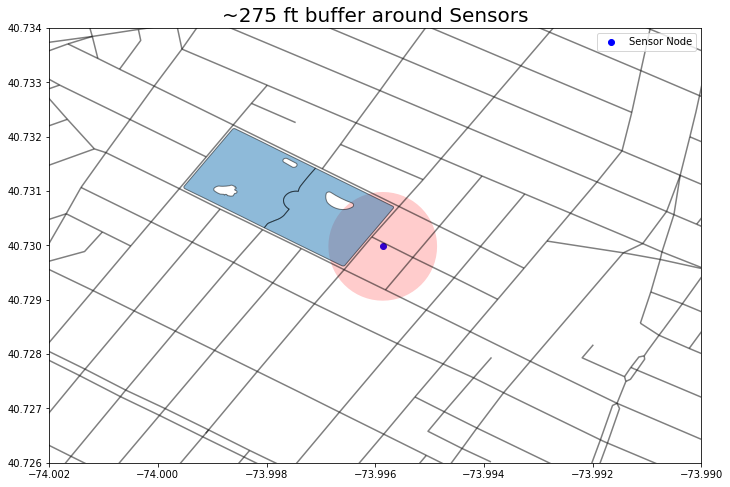

In [34]:
f, ax = plt.subplots(figsize=(12,8))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim((-74.002,-73.99))
ax.set_ylim((40.726,40.734))
nodes[nodes.index==0].plot(ax=ax,color='b', label = 'Sensor Node')
nodes[nodes.index==0].buffer(0.0010).plot(ax=ax, color='r', alpha = 0.2,
                                         label = 'Sensor buffer')
nycParks.plot(ax=ax, edgecolor='k',alpha=0.5, label='WSP')
streets.plot(ax=ax, edgecolor='k',alpha=0.5)
ax.legend()
plt.title("~275 ft buffer around Sensors", size=20)
plt.show()

In [35]:
node_buffer = nodes.copy()
for i in nodes.index:
    node_buffer['geometry'][i] = node_buffer['geometry'][i].buffer(0.0010)



/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
complaints.drop(columns = ['community_board', 'complaint_type', 'incident_zip', 'intersection_street_1', 'intersection_street_2',
       'location_type', 'index_right', 'propname'],inplace=True)


KeyError: "labels ['community_board' 'index_right' 'propname'] not contained in axis"

In [ ]:
node_complaints = sjoin(complaints, node_buffer)

In [ ]:
nodeBuffers = gp.GeoSeries(cascaded_union(node_buffer.geometry))

In [ ]:
f, ax = plt.subplots(figsize=(13,11))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim((-74.004,-73.99))
ax.set_ylim((40.726,40.736))
nodeBuffers.plot(ax=ax, color='y', edgecolor = 'k',alpha = 0.4, label = 'Node Buffer')
WSP_st_buffer.plot(ax=ax, color = 'k', alpha = 0.5)
nycParks.plot(ax=ax, edgecolor='k',alpha=0.5, label='WSP')
node_complaints.plot(ax=ax, color='blue', alpha = 0.5, label='Complaints')
nodes.plot(ax=ax, color= 'magenta',marker = 'v',
           markersize=100,label = 'Sensors')

ax.legend(title='Legend')

plt.title("Construction Noise Complaints Near WSP", size=20)
plt.show()

In [ ]:
noisyDays = node_complaints.groupby('createdate')[['createdate']].count()\
.sort_values('createdate', ascending=False).head(20).index

In [ ]:
noisyDays

## Complaint Heat Map

### Using Folium Library

In [ ]:
import folium
from folium.plugins import HeatMap
import time
import os
from selenium import webdriver
from selenium.webdriver.chrome.options import Options


In [ ]:
node_complaints['latitude'] = node_complaints['geometry'].y
node_complaints['longitude'] = node_complaints['geometry'].x
node_complaints['one'] = 1

In [ ]:
hmap = folium.Map(location = [40.7304798824251,-73.99658], 
                  zoom_start = 17)
    
marker_cluster = folium.MarkerCluster().add_to(hmap)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df_counters['Name'][point]).add_to(marker_cluster)
map2
hm_wide = HeatMap(list(zip(
        node_complaints[node_complaints.createdate == day].latitude.values, 
        node_complaints[node_complaints.createdate == day].longitude.values, 
        node_complaints[node_complaints.createdate == day].one.values))
                )
hmap.add_child(hm_wide)

#hm_sensors = 
 
hmap

In [ ]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  

for day in noisyDays[:2]:
    hmap = folium.Map(location = [40.7304798824251,-73.99658], 
                  zoom_start = 17)
    
    hm_wide = HeatMap(list(zip(
        node_complaints[node_complaints.createdate == day].latitude.values, 
        node_complaints[node_complaints.createdate == day].longitude.values, 
        node_complaints[node_complaints.createdate == day].one.values))
                )
    hmap.add_child(hm_wide)
    path = '{}.html'.format(day)
    hmap.save(path)

    browser = webdriver.Chrome(options=chrome_options)
    browser.get('file://{}/{}'.format(os.getcwd(),path))

    time.sleep(5)
    browser.save_screenshot('{}.png'.format(day))
    browser.quit()

hmap

In [ ]:
__author__ = 'Robert'
from images2gif import writeGif
from PIL import Image
import os

file_names = sorted((fn for fn in os.listdir('.') if fn.endswith('.png')))
#['animationframa.png', 'animationframb.png', 'animationframc.png', ...] "

images = [Image.open(fn) for fn in file_names]

print writeGif.__doc__
# writeGif(filename, images, duration=0.1, loops=0, dither=1)
#    Write an animated gif from the specified images.
#    images should be a list of numpy arrays of PIL images.
#    Numpy images of type float should have pixels between 0 and 1.
#    Numpy images of other types are expected to have values between 0 and 255.


#images.extend(reversed(images)) #infinit loop will go backwards and forwards.

filename = "my_gif.GIF"
writeGif(filename, images, duration=0.2)
#54 frames written
#
#Process finished with exit code 0

#### Daily Noise Complaints within Sensor Buffer Areas
This dataframe will be used to compare with the sensor data to see if the days where there are construction-related complaints, there is a period of excessive noise that occurred.

In [ ]:
node_complaints_daily = pd.DataFrame(
    node_complaints.groupby(['index_right','createdate'])['created_date'].count())
node_complaints_daily.rename(columns={'created_date':'count'},inplace=True)

In [ ]:
node_complaints_daily

In [ ]:
node_complaints['month'] = node_complaints['created_date'].apply(lambda x: x.month)

In [ ]:
node_complaints_monthly = pd.DataFrame(
    node_complaints.groupby(['index_right','month'])['created_date'].count())
node_complaints_monthly.rename(columns={'created_date':'count'},inplace=True)

In [ ]:
node_complaints_monthly